# Rate-control Empirical Analysis

## Simple linear regression

We performed a simple linear regression of the bitrate with respect to the quantizer,
operating on the logarithm of both.
The data set used was all of the video clips on https://media.xiph.org/video/derf/
as well as subset3 (for extra I-frame data).
To enable processing an arbitrarily large data set, an online regression algorithm was implemented.
In practice, [440MB of text formatted data](https://ba.rr-dav.id.au/data/rav1e/rc-data.tar.xz) were sufficient.

The raw final state of the online regression for each segment follows.

In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

from glob import glob
import numpy as np
from pprint import pprint
import tarfile
from tqdm import tqdm_notebook

# Klotz, Jerome H. "UPDATING SIMPLE LINEAR REGRESSION."
# Statistica Sinica 5, no. 1 (1995): 399-403.
# http://www.jstor.org/stable/24305577
def online_simple_regression(accumulator, x, y):
    Ax_, Ay_, Sxy, Sxx, n_, minx, maxx = accumulator or (0, 0, 0, 0, 0, None, None)

    first = n_ == 0
    n = n_ + x.size
    rt_n, rt_n_ = np.sqrt((n, n_), dtype=np.float128)

    Ax = (Ax_*n_ + x.sum(dtype=np.float128))/n
    Ay = (Ay_*n_ + y.sum(dtype=np.float128))/n
    
    minx = x.min() if first else min(minx, x.min())
    maxx = x.max() if first else max(maxx, x.max())
    
    X = Ax if first else (Ax_*rt_n_ + Ax*rt_n)/(rt_n_ + rt_n)
    Y = Ay if first else (Ay_*rt_n_ + Ay*rt_n)/(rt_n_ + rt_n)

    Sxx += np.sum((x - X)**2)
    Sxy += np.sum((x - X)*(y - Y))

    return Ax, Ay, Sxy, Sxx, n, minx, maxx

def conv_px(s):
    w, h = s.split(b'x')
    return int(w)*int(h)

conv_fti = [b'I', b'P', b'B0', b'B1'].index

def collect(filename, queues):
    px, log_target_q, byte_size, frame_type = np.loadtxt(
        filename, dtype=np.int64, delimiter=',',
        converters={1: conv_px, 4: conv_fti},
        skiprows=1, usecols=range(1, 5), unpack=True)

    blog64q57_ibpp = np.round((
        np.log2(px, dtype=np.float128) - np.log2(byte_size*8, dtype=np.float128)
    )*2**57).astype(np.int64)
    
    # These are the fixed point found by repeating this whole process
    boundaries = [
        [0, 381625*2**40, 655352*2**40, 967797*2**40],
        [0, 356802*2**40, 848173*2**40, 967797*2**40],
        [0, 288436*2**40, 671307*2**40, 967797*2**40],
        [0, 264708*2**40, 622760*2**40, 967797*2**40]
    ]

    for fti in np.unique(frame_type):
        buckets = list(zip(boundaries[fti][:-1], boundaries[fti][1:]))
        for bi, bucket in enumerate(buckets):
            low, high = bucket
            idx = (frame_type==fti) & (log_target_q >= low) & (log_target_q < high)
            if np.sum(idx, dtype=int) == 0: continue
            b = (bi << 2) | fti
            x, y = log_target_q[idx], blog64q57_ibpp[idx]
            queue = queues.get(b, ([], []))
            queue[0].append(x)
            queue[1].append(y)
            queues[b] = queue

def aggregate(queues, partials):
    for b, queue in queues.items():
        x, y = np.concatenate(queue[0]), np.concatenate(queue[1])
        partials[b] = online_simple_regression(partials.get(b, None), x, y)
    queues.clear()

partials = dict()
# https://ba.rr-dav.id.au/data/rav1e/rc-data.tar.xz
with tarfile.open('rc-data.tar.xz', 'r:xz') as tf:
    queues, last_name = dict(), None
    for ti in tqdm_notebook(tf, total=1077*255, leave=False):
        name = ti.name.split('/')[0]
        if last_name and name != last_name:
            aggregate(queues, partials)
        last_name = name
        collect(tf.extractfile(ti), queues)
    aggregate(queues, partials)
pprint(partials)

{0: (2.7695336845023429016e+17,
     -1.07133222745900214305e+17,
     8.397389236899963756e+38,
     1.1092601296011764081e+39,
     91218,
     9581914802246888,
     419495824559273192),
 1: (2.5070212498929263503e+17,
     -1.5282410383799979604e+16,
     5.773449575496993589e+39,
     5.3433937458969078745e+39,
     469305,
     0,
     389174377867415552),
 2: (2.1203328628257383575e+17,
     64756017185446.597675,
     1.7081708964304293988e+39,
     1.3053204002923686526e+39,
     222579,
     56629159325661976,
     317096453837818648),
 3: (2.07697267279316528e+17,
     2.6367481275468926898e+16,
     8.87068088650291795e+38,
     6.4929291690119722136e+38,
     232617,
     113258318651323952,
     281862280268830256),
 4: (5.5969475326659699072e+17,
     1.33446813443680867414e+17,
     9.2122867143093983015e+38,
     9.627956722873028641e+38,
     122946,
     422111132843500776,
     719865965107815656),
 5: (6.456860630541701375e+17,
     5.6144108286815278803e+17,
     

## Fixed-point approximation

The regression results are converted to a fixed-point representation,
with the exponent in Q6 and the scale in Q3.

 I: exp=48 scale=36 bucket=0
 I: exp=61 scale=55 bucket=1
 I: exp=77 scale=129 bucket=2
 P: exp=69 scale=32 bucket=0
B0: exp=84 scale=30 bucket=0
B1: exp=87 scale=27 bucket=0
B1: exp=139 scale=84 bucket=1
B0: exp=120 scale=68 bucket=1
 P: exp=104 scale=84 bucket=1
B1: exp=61 scale=1 bucket=2
B0: exp=68 scale=4 bucket=2
 P: exp=83 scale=19 bucket=2


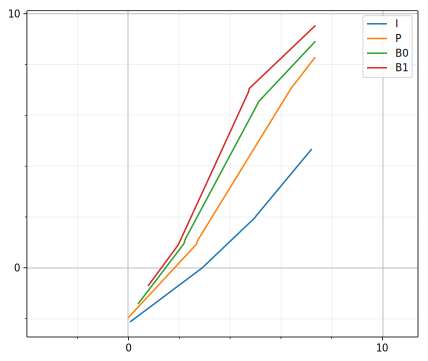

In [2]:
plt.figure(figsize=(7, 6))
plt.axis('equal')
plt.xticks([0, 10])
plt.yticks([0, 10])
plt.minorticks_on()
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor', alpha=0.2)

segments = dict()
for b, accumulator in partials.items():
    Ax, Ay, Sxy, Sxx, n, minx, maxx = accumulator


    fti = b & 3
    beta = Sxy/Sxx
    alpha = Ay - beta*Ax
    exp = int(np.round(beta*2**6))
    beta_ = exp/2**6
    alpha_ = Ay - beta_*Ax
    scale = int(np.round(np.exp2(3 - alpha_/2**57)))
    label = ['I', 'P', 'B0', 'B1'][fti]
    print('%2s: exp=%d scale=%d bucket=%d' % (label, exp, scale, b>>2))

    xs, ys = segments.get(label, ([], []))
    xs = [minx/2**57, maxx/2**57]
    ys = [xs[0]*beta_ + alpha_/2**57, xs[1]*beta_ + alpha_/2**57]
    xs_, ys_ = segments.get(label, ([], []))
    xs_.extend(xs)
    ys_.extend(ys)
    segments[label] = (xs_, ys_)

best = dict()
for label, xy in segments.items():
    plt.plot(xy[0], xy[1], label=label)
    
plt.legend();

The endpoints of each linear regression, rounding only the exponent, are detailed in the following output.
We use a cubic interpolation of these points to adjust the segment boundaries.

In [3]:
pprint(segments)

{'B0': ([0.39294372842822706,
         2.2002986504858395,
         2.250924723555803,
         5.114042917135398,
         5.137773646423531,
         7.379457452900416],
        [-1.4148623981702452337,
         0.95729093703037120824,
         1.1300545385380504622,
         6.4984011514997921106,
         6.5594675085524934565,
         8.941256552934184157]),
 'B1': ([0.7858874568564541,
         1.955812458298777,
         2.0338149703000394,
         4.745877754380938,
         4.768869761992487,
         7.380207231894769],
        [-0.7078397903627942796,
         0.88252700847286351155,
         1.032874654152443289,
         6.9231360133281455494,
         7.0480332114869880963,
         9.536964237487599543]),
 'I': ([0.06648789020906937,
        2.910837019748877,
        2.928984366459142,
        4.995073556916916,
        5.018565704152715,
        7.21693359533783],
       [-2.1348326785650876126,
        -0.0015708314102318150611,
        0.016045673317236682116,
    

## Piecewise-linear fit

We applied a 3-segment piecewise-linear fit. The boundaries were aligned to integer values of pixels-per-bit,
while optimizing for similarity to a cubic interpolation of the control points
(log-quantizer as a function of log-bitrate).

I [1. 4.] [381625. 655352.]
P [  2. 139.] [356802. 848173.]
B0 [ 2. 92.] [288436. 671307.]
B1 [  2. 126.] [264708. 622760.]


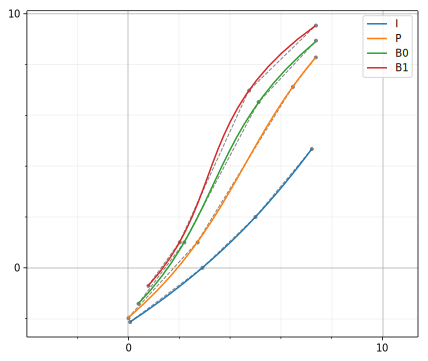

In [4]:
plt.figure(figsize=(7, 6))
plt.axis('equal')
plt.xticks([0, 10])
plt.yticks([0, 10])
plt.minorticks_on()
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor', alpha=0.2)

from scipy import optimize

for ft, xy in segments.items():
    f = np.poly1d(np.polyfit(np.array(xy[1]).astype(float), np.array(xy[0]).astype(float), 3))
    ys = np.linspace(min(xy[1]), max(xy[1]), 20)
    def cost(X):
        y0 = np.array([ys[0], X[0], X[1], ys[-1]]).astype(float)
        x0 = f(y0)
        f0 = np.where(ys<X[0],
                      np.poly1d(np.polyfit(y0[:2], x0[:2], 1))(ys),
                      np.where(ys<X[1],
                              np.poly1d(np.polyfit(y0[1:3], x0[1:3], 1))(ys),
                              np.poly1d(np.polyfit(y0[2:], x0[2:], 1))(ys)))
        return ((f0-f(ys))**2).sum()
    X = optimize.fmin(cost, [2, 5], disp=0)
    X = np.log2(np.ceil(np.exp2(X)))
    print(ft, np.exp2(X), np.round(f(X)*2**17))
    y0 = [ys.min(), X[0], X[1], ys.max()]
    x0 = f(y0)
    plt.plot(x0, y0, '.--', lw=1, c='grey')
    plt.plot(f(ys), ys, label=ft)

plt.legend();